# Homework 6

## FINM 36700 - 2023

### UChicago Financial Mathematics

* Younghun Lee
* hun@uchicago.edu

In [1]:
from functools import partial
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sys
if '../cmds/' not in sys.path:
    sys.path.append('../cmds/')
# from TA_utils import *
# from portfolio import *

import warnings
warnings.filterwarnings("ignore")

## 1 The Momentum Product
This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.

### 1.1 What is novel about the AQR Momentum product under construction compared to the various momentum investment products already offered?

- The AQR's Momentum product is a mutual fund, and thus any retail investors can invest.
- Two characterisitcs of mutual fund:
  1. Long-only: legally limited in their use of short positions and leverage
  2. Open-end: had to be ready to return capital at the end of the trading day to respond to investor redemptions

### 1.2 Name three reasons the momentum investment product will not exactly track the momentum index, (ie. why the strategy will have tracking error.)

1. AQR's fund would be long-only, whereas the index (Fama-french UMD) is long-short.
2. The index assumes monthly rebalancing, which may cause huge transaction cost. 
3. Fama-French UMD used all listed stocks, whereas AQR's fund would only use stocks with reasonable market capitalization and liquidity. This is because of "open-end" mutual fund regulation.

### 1.3 When constructing the momentum portfolio, AQR ranks stocks on their returns from month $t-12$ through $t-2$. Why don't they include the $t-1$ return in this ranking?

- The winning/losing stocks between $t − 1$ to $t$ may show short-term reversal, such that the momentum strategy would be hurt by including $t − 1$ return in the ranking.

## 2. Investigating Momentum

In this section, we empirically investigate some concerns regarding AQR's new momentum product.
On Canvas, find the data file, "**momentum_data.xlsx**".
- The first tab contains the momentum factor as an excess return: $\tilde{r}^{\mathrm{mom}}$.
- The second tab contains returns on portfolios corresponding to scored momentum deciles.
  - $r^{\operatorname{mom}(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the "losers" with the lowest past returns.
  - $r^{\operatorname{mom}(10)}$ denotes the portfolio of stocks in the highest momentum decile.
- The third tab gives portfolios sorted by momentum and size.
  - $r^{\text {momsu }}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
  - $r^{\text {momBD }}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.

Note that the Fama-French momentum return, $\tilde{r}^{\mathrm{mom}: \mathrm{FF}}$, given in the first tab, is constructed by $\mathrm{FF}$ as,

$$
\tilde{r}^{\mathrm{mom}: \mathrm{FF}}=\frac{1}{2}\left(r^{\mathrm{momBU}}+r^{\mathrm{momSU}}\right)-\frac{1}{2}\left(r^{\mathrm{momBD}}+r^{\mathrm{momSD}}\right)
$$

In [2]:
raw_data = pd.read_excel('../data/momentum_data.xlsx',sheet_name = None)
sheets = list(raw_data.keys())

ff_factors = raw_data[sheets[1]].set_index('Date')
momentum = raw_data[sheets[2]].set_index('Date')
mom_deciles = raw_data[sheets[3]].set_index('Date')
tercile_port = raw_data[sheets[4]].set_index('Date')
rf = raw_data[sheets[5]].set_index('Date')

ff_factors['UMD'] = momentum['UMD']

The Fama-French momentum return

$$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1 Is Momentum sill profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2023?

Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

#### (a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{\text {mom:FF }}$.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { Subsample } \quad \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline & & & & \\
1927-2023 & & & \\
1927-1993 & & & \\
2009-2023 & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [3]:
def calc_return_metrics(data, as_df=False, adj=12):
    """
    Calculate return metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False (return a dict).
        adj (int, optional): Annualization. Defaults to 12.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of return metrics.
    """
    summary = dict()
    summary["Annualized Return"] = data.mean() * adj
    summary["Annualized Volatility"] = data.std() * np.sqrt(adj)
    summary["Annualized Sharpe Ratio"] = (
        summary["Annualized Return"] / summary["Annualized Volatility"]
    )
    summary["Annualized Sortino Ratio"] = summary["Annualized Return"] / (
        data[data < 0].std() * np.sqrt(adj)
    )
    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_risk_metrics(data, as_df=False, var=0.05):
    """
    Calculate risk metrics for a DataFrame of assets.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        as_df (bool, optional): Return a DF or a dict. Defaults to False.
        adj (int, optional): Annualizatin. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        Union[dict, DataFrame]: Dict or DataFrame of risk metrics.
    """
    summary = dict()
    summary["Skewness"] = data.skew()
    summary["Excess Kurtosis"] = data.kurtosis()
    summary[f"VaR ({var})"] = data.quantile(var, axis=0)
    summary[f"CVaR ({var})"] = data[data <= data.quantile(var, axis=0)].mean()
    summary["Min"] = data.min()
    summary["Max"] = data.max()

    wealth_index = 1000 * (1 + data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary["Max Drawdown"] = drawdowns.min()

    summary["Bottom"] = drawdowns.idxmin()
    summary["Peak"] = previous_peaks.idxmax()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][: drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )
    summary["Recovery"] = ["-" if pd.isnull(i) else i for i in recovery_date]

    summary["Duration (days)"] = [
        (i - j).days if i != "-" else "-"
        for i, j in zip(summary["Recovery"], summary["Bottom"])
    ]

    return pd.DataFrame(summary, index=data.columns) if as_df else summary


def calc_performance_metrics(data, adj=12, var=0.05):
    """
    Aggregating function for calculating performance metrics. Returns both
    risk and performance metrics.

    Args:
        data (pd.DataFrame): DataFrame of asset returns.
        adj (int, optional): Annualization. Defaults to 12.
        var (float, optional): VaR level. Defaults to 0.05.

    Returns:
        DataFrame: DataFrame of performance metrics.
    """
    summary = {
        **calc_return_metrics(data=data, adj=adj),
        **calc_risk_metrics(data=data, var=var),
    }
    summary["Calmar Ratio"] = summary["Annualized Return"] / abs(
        summary["Max Drawdown"]
    )
    return pd.DataFrame(summary, index=data.columns)


In [4]:
periods = [['1927', '2022'], ['1927', '1993'], ['1994', '2008'], ['2009', '2023']]
summary_col_names = ['Annualized Return','Annualized Volatility','Annualized Sharpe Ratio','Skewness']
res = []
for period in periods:
    temp = momentum.loc[period[0]:period[1]]
    temp_ff = ff_factors.loc[period[0]:period[1]]
    summary = calc_performance_metrics(temp)[summary_col_names]
    summary['mkt_corr'] = temp_ff.corr().loc['MKT',['UMD']]
    summary['val_corr'] = temp_ff.corr().loc['HML',['UMD']]
    summary = summary.T.iloc[:,0].rename(f'{period[0]} - {period[1]}')
    res.append(summary)
summary  = pd.concat(res, axis=1).T
summary

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
1927 - 2022,0.077630,0.162569,0.477522,-3.014032,-0.344384,-0.414965
1927 - 1993,0.090081,0.160003,0.562992,-3.808207,-0.362496,-0.495002
1994 - 2008,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.129361
2009 - 2023,-0.023767,0.160638,-0.147952,-2.689060,-0.380867,-0.313299


#### (b) Has momentum changed much over time, as seen through these subsample statistics?

It doesn't change much in the most of the periods. But the momentum is showing negative return after 2009.

#### (c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

Yes, It was definitely profitable at 2008 when AQR was considering to launch the momentum product. Also, the momentum has a low correlation with market and value factor, which makes it a good diversifier. Even if the mean return is near zero, the momentum is still valuable because of its low correlation with other factors.

### 2.2. Whether a long-only implementation of momentum is valuable.

Construct your own long-only implementation:

$$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

$$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


#### (a) Fill out Table 2 for the data in the period 1994-2022.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 2: Long-only momentum performance. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2023 } & \text { mean } \quad \text { vol } & \text { Sharpe } & \text { skew } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \text { Long-and-short, }\left(\tilde{r}^{\text {mom:FF }}\right) & & & \\
\text { Long-only }\left(\tilde{r}^{\text {momU:FF }}\right) & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [8]:
mom_long = (tercile_port['BIG HiPRIOR'] + tercile_port['SMALL HiPRIOR'])/2 - rf['RF']
mom_names = ['long_and_short','long_only']

temp = ff_factors.copy().rename(columns={'UMD':'long_and_short'})
temp['long_only']  = mom_long
summary = calc_performance_metrics(temp.loc["1994":, mom_names])[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', mom_names]
summary['val_corr'] = temp.corr().loc['HML', mom_names]
summary

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
long_and_short,0.043184,0.167682,0.257534,-1.445951,-0.344284,-0.406410
long_only,0.117195,0.178410,0.656885,-0.444802,0.935817,0.210531


In [12]:
temp

,MKT,SMB,HML,long_and_short,long_only
Date,,,,,
1927-01-31,-0.0006,-0.0037,0.0454,0.0036,-0.00050
1927-02-28,0.0418,0.0004,0.0294,-0.0214,0.04730
1927-03-31,0.0013,-0.0165,-0.0261,0.0361,-0.00200
1927-04-30,0.0046,0.0030,0.0081,0.0430,0.02315
1927-05-31,0.0544,0.0153,0.0473,0.0300,0.06705
...,...,...,...,...,...
2024-05-31,0.0434,0.0078,-0.0166,-0.0002,0.05145
2024-06-30,0.0277,-0.0306,-0.0331,0.0090,0.00745
2024-07-31,0.0124,0.0680,0.0573,-0.0242,0.03995


#### (b)  Is long-only momentum as attractive as long-short momentum with respect to mean, volatil-ity, and Sharpe Ratio?

Yes, long-only looks even more attractive than long-short momentum. The mean return is higher, while the volatility is similar. Sharpe ratio is higher as well.

#### (c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?


No, the long-only momentum portfolio has 93.6% of correlation with market, whereas the long-short momentum portfolio has -34% of correlation with market. This is because the long-only momentum portfolio is still exposed to market risk.

#### (d) Show a plot of the cumulative product of $1+\tilde{r}^{\text {mom:FF }}$ and $1+\tilde{r}^{\text {momU:FF }}$ over the 1994-2023 subsample. $^2$

<Axes: xlabel='Date'>

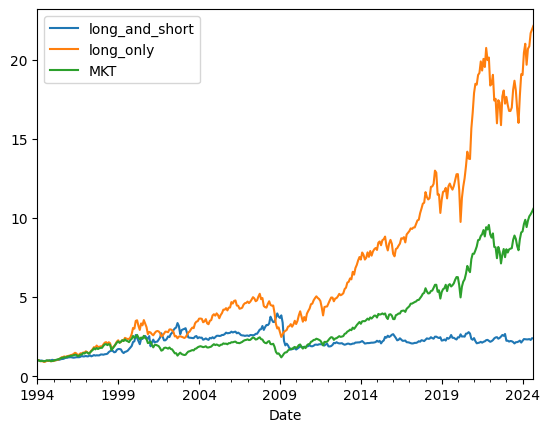

In [13]:
(1 + temp[mom_names + ['MKT']].loc['1994':]).cumprod().plot()

### 2.3. Is momentum just data mining, or is it a robust strategy?

Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:

- long the top 1 decile and short the bottom 1 deciles:

$$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$

- long the top 3 deciles and short the bottom 3 deciles:


$$ 
\begin{aligned}
\tilde{r}^{momD3} &= \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)})\\
&= \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} 
\end{aligned}$$


- long the top 5 deciles and short the bottom 5 decile:

$$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

#### (a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2023.

$$
\begin{equation}
\begin{aligned}
&\text { Table 3: Robustness of momentum construction. }\\
&\begin{array}{lllllll}
\hline \hline \text { 1994-2023 } \quad \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}^m & \text { corr. to } \tilde{r}^v \\
\hline \hline \tilde{r}^{\text {momD1 }} & & & & & \\
\tilde{r}^{\text {momD3 }} & & & & \\
\tilde{r}^{\text {momD5 }} & & & & \\
\hline \hline
\end{array}
\end{aligned}
\end{equation}
$$

In [35]:
ls_1decile = mom_deciles['Hi PRIOR'] - mom_deciles['Lo PRIOR']
ls_3decile = mom_deciles.iloc[:,-3:].mean(axis = 1) - mom_deciles.iloc[:,:3].mean(axis = 1)
ls_5decile = mom_deciles.iloc[:,-5:].mean(axis = 1) - mom_deciles.iloc[:,:5].mean(axis = 1)

ls_names = ['mom_D1','mom_D3','mom_D5']
temp = ff_factors.copy()
temp[ls_names] = pd.concat([ls_1decile, ls_3decile, ls_5decile], axis=1)
summary = calc_performance_metrics(temp.loc["1994":, ls_names + ['UMD']])[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ls_names + ['UMD']]
summary['val_corr'] = temp.corr().loc['HML', ls_names + ['UMD']]
summary

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
mom_D1,0.074873,0.298583,0.250762,-1.307240,-0.372584,-0.400235
mom_D3,0.024814,0.194199,0.127774,-1.350529,-0.384224,-0.393174
mom_D5,0.013016,0.134476,0.096792,-1.428013,-0.364508,-0.388217
UMD,0.040090,0.169641,0.236324,-1.437432,-0.346337,-0.404836


In [14]:
mom_deciles

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR
Date,,,,,,,,,,
1927-01-31,-0.0332,-0.0446,0.0269,-0.0033,-0.0041,0.0097,0.0074,0.0036,-0.0041,-0.0024
1927-02-28,0.0753,0.0593,0.0825,0.0727,0.0322,0.0421,0.0283,0.0326,0.0420,0.0701
1927-03-31,-0.0323,-0.0301,-0.0392,-0.0477,-0.0048,-0.0242,0.0205,0.0041,0.0096,0.0547
1927-04-30,0.0204,-0.0320,-0.0247,-0.0137,0.0220,-0.0005,0.0205,-0.0059,0.0159,0.0549
1927-05-31,0.0272,0.0457,0.0595,0.0318,0.0636,0.0580,0.0496,0.0681,0.0811,0.0632
...,...,...,...,...,...,...,...,...,...,...
2024-05-31,0.0562,0.0300,0.0614,0.0105,0.0208,0.0354,0.0451,0.0421,0.0100,0.1182
2024-06-30,-0.0244,0.0045,0.0397,0.0200,0.0030,0.0300,0.0258,0.0358,0.0528,0.0683
2024-07-31,0.1233,0.0358,0.0351,0.0590,0.0444,0.0409,0.0056,0.0152,-0.0092,-0.0469


#### (b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

Yes, we can see long-short portfolio with higher threshold of decile has higher return, but also higher volatility.

#### (c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

I would recommend 1-decile, as it has higher sharpe.

#### (d) Does $\tilde{r}^{\text {momD3 }}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

They are similar, but Fama-French construction has higher return and lower volatility, resulting with higher sharpe ratio. Fama-French construction allows balance between small and large stocks, whereas top 3 deciles construction could be biased towards either small or large stocks.

### 2.4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)

Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

$$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

Similarly, use the data provided to construct a big-stock momentum portfolio,

$$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

#### (a) Fill out Table 4 over the sample 1994-2023.

$$
\begin{equation*}
\begin{aligned}
&\text { Table 4: Momentum of small and big stocks. }\\
&\begin{array}{llllll}
\hline \hline \text { 1994-2023 } & \text { mean } & \text { vol } & \text { Sharpe } & \text { skewness } & \text { corr. to } \tilde{r}[m] \\
\hline \hline \text { All stocks, } \tilde{r}^{\text {mom:FF }} & & & & \\
\text { Small stocks } r_t^{\text {mom } S} & & & \\
\text { Large stocks } r_t^{\text {mom } B} & & & \\
\hline
\end{array}
\end{aligned}
\end{equation*}
$$

In [36]:
mom_small = tercile_port['SMALL HiPRIOR'] - tercile_port['SMALL LoPRIOR']
mom_large = tercile_port['BIG HiPRIOR'] - tercile_port['BIG LoPRIOR']

mom_size_name = ['Small_stocks','Big_stocks']
temp = ff_factors.copy()
temp[mom_size_name] = pd.concat([mom_small, mom_large], axis=1)
summary = calc_performance_metrics(temp.loc["1994":, ['UMD'] + mom_size_name])[summary_col_names]
summary['mkt_corr'] = temp.corr().loc['MKT', ['UMD'] + mom_size_name]
summary['val_corr'] = temp.corr().loc['HML', ['UMD'] + mom_size_name]
summary.rename({'UMD':'All_stocks'})

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Skewness,mkt_corr,val_corr
All_stocks,0.040090,0.169641,0.236324,-1.437432,-0.346337,-0.404836
Small_stocks,0.059358,0.171924,0.345256,-1.744008,-0.332939,-0.388788
Big_stocks,0.020799,0.183927,0.113082,-0.877121,-0.327545,-0.383182


#### (b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

Yes, the small stock momentum portfolio has almost 3 time higher sharpe ratio than the large stock momentum portfolio. Still, the large stock momentum portfolio delivers positive excess return.

### 2.5. In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

- AQR's retail product uses a long only approach which leads to a higher correlation with the Market and has less diversification benefits compared to the benchmark index or Fama-French momentum factor.
- Quarterly rebalancing might make the portfolio diverge from the benchmark index and Fama-French momentum factor.

# 4.1

In [23]:
data = pd.read_excel('../data/barnstable_analysis_data.xlsx', sheet_name=1).set_index('date').fillna(method = 'ffill')
data['excess_returns'] = data['SPX'] - data['TB1M'] 
rets = data['excess_returns']
data.head()

,SPX,TB1M,excess_returns
date,,,
1926-01-30,-0.001783,0.003061,-0.004844
1926-02-27,-0.033297,0.002612,-0.035909
1926-03-31,-0.057708,0.002601,-0.060309
1926-04-30,0.038522,0.002270,0.036252
1926-05-28,0.013623,0.002691,0.010932


In [24]:
agg_years = [(1965, 1999), (2000, 2023), (1926, 2023)]
def calc_analytics_by_year(data, agg_years):
    res = []
    for y in agg_years:
        sub = data.loc[str(y[0]):str(y[1])]
        res.append({'mean': sub.mean() * 12, 'vol': sub.std() * np.sqrt(12)})
    return pd.DataFrame(res, index = [f'{i[0]} - {i[1]}' for i in agg_years]).stack()

sum_stats = data.apply(calc_analytics_by_year, agg_years = agg_years).T
sum_stats.index = ['r_M', 'r_f', 'r_^M']
log_sum_stats = np.log(1 + data).apply(calc_analytics_by_year, agg_years = agg_years).T

res_stats = pd.concat([sum_stats, log_sum_stats])
res_stats.index = pd.MultiIndex.from_product([['levels','logs'], sum_stats.index.to_list()])
res_stats.style.format('{:,.2%}')

SPX underperforming RF in the next 15 years after 1999: 7.42%
SPX underperforming RF in the next 30 years after 1999: 2.05%


<Axes: >

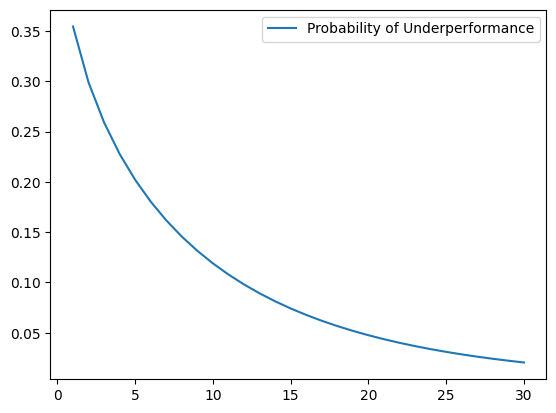

In [25]:
from scipy.stats import norm
def prob(mu, sigma, h):
    return norm.cdf(np.sqrt(h)*mu/sigma)

mu, sigma = res_stats['1965 - 1999'].loc[('logs', 'r_^M')]

print(f'SPX underperforming RF in the next 15 years after 1999: {prob(mu = -mu, sigma = sigma, h = 15):,.2%}')

print(f'SPX underperforming RF in the next 30 years after 1999: {prob(mu = -mu, sigma = sigma, h = 30):,.2%}')

h = np.arange(30) + 1
probs = pd.DataFrame([prob(-mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot()

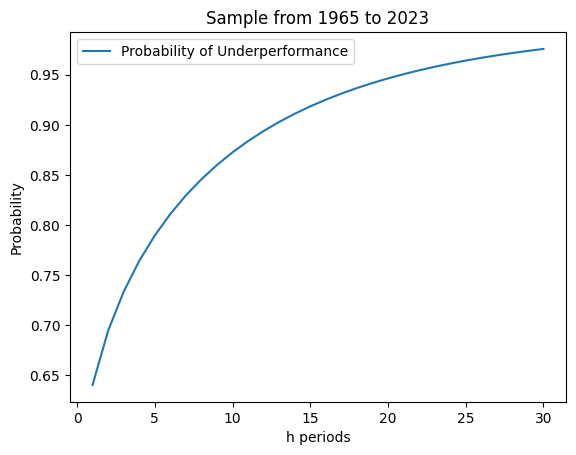

In [26]:
mu = np.log(1+rets.loc['1965':'2023']).mean() * 12
sigma = np.log(1+rets.loc['1965':'2023']).std() * np.sqrt(12)
h = np.arange(30)+1

probs = pd.DataFrame([prob(mu, sigma, x) for x in h], columns=['Probability of Underperformance'], index = h)
probs.plot(title = 'Sample from 1965 to 2023', ylabel = 'Probability', xlabel = 'h periods')
plt.show()

In [28]:
mu = res_stats[('1965 - 1999', 'mean')].loc[('logs', 'r_M')] - res_stats[('2000 - 2023', 'mean')].loc[('logs', 'r_M')]
sigma = res_stats[('1965 - 1999', 'vol')].loc[('logs', 'r_M')]

print(f"Probability of underperformance in 2000-2023: {prob(-mu, sigma, 24):,.2%}")

Probability of underperformance in 2000-2023: 5.64%
